# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a91c620f98f9551f8d0cdfa55a32d1efe780367b204507660b29ba7e2e2f3a03
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=ae8f2a08aebc561fd303a5e6a1f713aff3208f91c96669785457356718c8f3cf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


In [5]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


#EOF


## DataSet

In [6]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


In [7]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [8]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 202: 


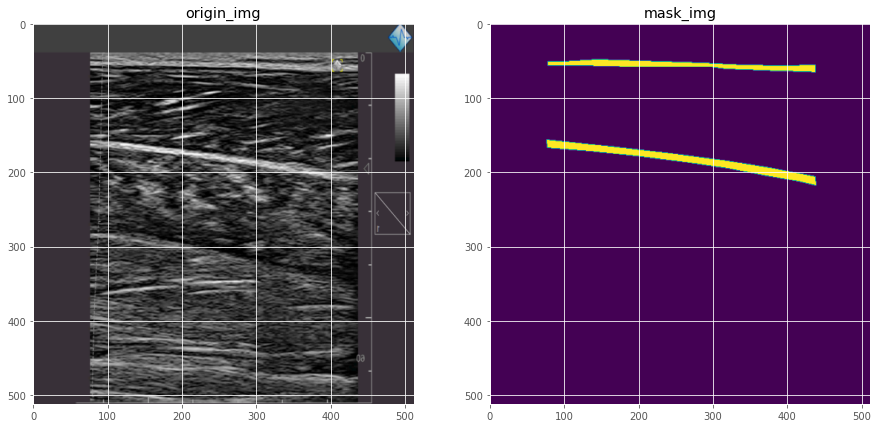

In [9]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [10]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt


import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb


class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=512, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=2, embed_dims=[128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.n_classes = num_classes
        self.n_channels = input_channels
        
        self.encoder1 = nn.Conv2d(input_channels, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=2, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


In [11]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [12]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


In [13]:
model = UNext(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)

train(model, device, project='U-Next')


Let's use 2 GPUs!


wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


Validation round: 100%|██████████| 115/115 [00:05<00:00, 19.82batch/s]


Validation dice loss: 3.1079976558685303, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.56batch/s]


Validation dice loss: 3.006009101867676, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.24batch/s]


Validation dice loss: 2.9382922649383545, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.11batch/s]


Validation dice loss: 2.465519428253174, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.39batch/s]


Validation dice loss: 2.1585350036621094, IoU Score 0.4299059212207794


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.99batch/s]


Validation dice loss: 1.785072684288025, IoU Score 0.535568118095398


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.46batch/s]


Validation dice loss: 1.6374998092651367, IoU Score 0.5690591931343079


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.58batch/s]


Validation dice loss: 1.413832187652588, IoU Score 0.5526994466781616


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.28batch/s]


Validation dice loss: 1.3090085983276367, IoU Score 0.5643638968467712


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.40batch/s]


Validation dice loss: 1.2597016096115112, IoU Score 0.5160924792289734


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.10batch/s]


Validation dice loss: 1.1652833223342896, IoU Score 0.5697891712188721


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.77batch/s]


Validation dice loss: 1.1236050128936768, IoU Score 0.5872712731361389


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.24batch/s]


Validation dice loss: 1.0840325355529785, IoU Score 0.5651351809501648


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.13batch/s]


Validation dice loss: 1.0031791925430298, IoU Score 0.5913349986076355


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.18batch/s]


Validation dice loss: 1.0118638277053833, IoU Score 0.5592352747917175


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.55batch/s]


Validation dice loss: 0.9674861431121826, IoU Score 0.5592845678329468


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.68batch/s]


Validation dice loss: 0.8570525050163269, IoU Score 0.5784934163093567


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.70batch/s]


Validation dice loss: 0.7749272584915161, IoU Score 0.5393826961517334


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.33batch/s]


Validation dice loss: 0.6680246591567993, IoU Score 0.5964053869247437


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.10batch/s]


Validation dice loss: 0.636464536190033, IoU Score 0.5876665115356445


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.46batch/s]


Validation dice loss: 0.5862888693809509, IoU Score 0.6141457557678223


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.76batch/s]


Validation dice loss: 0.6271100640296936, IoU Score 0.5721120238304138


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.96batch/s]


Validation dice loss: 0.5814505219459534, IoU Score 0.586258053779602


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.79batch/s]


Validation dice loss: 0.5427420735359192, IoU Score 0.6132709383964539


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.47batch/s]


Validation dice loss: 0.5492834448814392, IoU Score 0.6136736869812012


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.61batch/s]


Validation dice loss: 0.5511705279350281, IoU Score 0.6054232120513916


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.32batch/s]


Validation dice loss: 0.4987013339996338, IoU Score 0.632652997970581


Validation round: 100%|██████████| 115/115 [00:02<00:00, 38.67batch/s]


Validation dice loss: 0.5056778788566589, IoU Score 0.6250624060630798


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.83batch/s]


Validation dice loss: 0.6208471655845642, IoU Score 0.5636487007141113


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.67batch/s]


Validation dice loss: 0.5771119594573975, IoU Score 0.5856305956840515


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.89batch/s]


Validation dice loss: 0.6141874194145203, IoU Score 0.5680097937583923


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.00batch/s]


Validation dice loss: 0.5010777711868286, IoU Score 0.6309388875961304


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.42batch/s]


Validation dice loss: 0.5327541828155518, IoU Score 0.5944221615791321


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.36batch/s]


Validation dice loss: 0.4491403102874756, IoU Score 0.6462526917457581


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.99batch/s]


Validation dice loss: 0.6168479323387146, IoU Score 0.5676469206809998


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.33batch/s]


Validation dice loss: 0.4799898862838745, IoU Score 0.6357409358024597


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.84batch/s]


Validation dice loss: 0.46731820702552795, IoU Score 0.6346216797828674


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.43batch/s]


Validation dice loss: 0.48258620500564575, IoU Score 0.6410914063453674


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.72batch/s]


Validation dice loss: 0.5072526931762695, IoU Score 0.6212649345397949


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.77batch/s]


Validation dice loss: 0.5686672329902649, IoU Score 0.5987637042999268


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.05batch/s]


Validation dice loss: 0.5241462588310242, IoU Score 0.6223602294921875


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.29batch/s]


Validation dice loss: 0.47468799352645874, IoU Score 0.6417569518089294


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.98batch/s]


Validation dice loss: 0.48515161871910095, IoU Score 0.6385879516601562


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.37batch/s]


Validation dice loss: 0.46863263845443726, IoU Score 0.6545470356941223


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.77batch/s]


Validation dice loss: 0.4834786355495453, IoU Score 0.6475065350532532


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 0.4813774526119232, IoU Score 0.6466230750083923


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.88batch/s]


Validation dice loss: 0.5299692749977112, IoU Score 0.6229546070098877


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.69batch/s]


Validation dice loss: 0.4665062427520752, IoU Score 0.6422938704490662


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.30batch/s]


Validation dice loss: 0.5288929343223572, IoU Score 0.6165386438369751


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.50batch/s]


Validation dice loss: 0.5082188844680786, IoU Score 0.6260104775428772


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.74batch/s]


Validation dice loss: 0.4727071523666382, IoU Score 0.6544833779335022


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.11batch/s]


Validation dice loss: 0.5112544894218445, IoU Score 0.6275784373283386


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.34batch/s]


Validation dice loss: 0.5032908916473389, IoU Score 0.6345137357711792


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.66batch/s]


Validation dice loss: 0.5121874809265137, IoU Score 0.6302564144134521


Validation round: 100%|██████████| 115/115 [00:03<00:00, 38.11batch/s]


Validation dice loss: 0.4803370237350464, IoU Score 0.6453230977058411


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.82batch/s]


Validation dice loss: 0.48887014389038086, IoU Score 0.646743893623352


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.25batch/s]


Validation dice loss: 0.5904765725135803, IoU Score 0.5768315196037292


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.59batch/s]


Validation dice loss: 0.5997340083122253, IoU Score 0.5731648206710815


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.12batch/s]


Validation dice loss: 0.4900146722793579, IoU Score 0.6371699571609497


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.25batch/s]


Validation dice loss: 0.4833853840827942, IoU Score 0.6393662095069885


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.87batch/s]


Validation dice loss: 0.5357775688171387, IoU Score 0.6121710538864136


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.04batch/s]


Validation dice loss: 0.4857158958911896, IoU Score 0.652313232421875


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.84batch/s]


Validation dice loss: 0.5020626187324524, IoU Score 0.6339220404624939


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.05batch/s]


Validation dice loss: 0.5498590469360352, IoU Score 0.6131869554519653


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.91batch/s]


Validation dice loss: 0.4955088496208191, IoU Score 0.6280850172042847


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.09batch/s]


Validation dice loss: 0.5232395529747009, IoU Score 0.6217647790908813


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.04batch/s]


Validation dice loss: 0.5621930956840515, IoU Score 0.5999936461448669


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.73batch/s]


Validation dice loss: 0.5468838810920715, IoU Score 0.6267029047012329


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.19batch/s]


Validation dice loss: 0.4904308021068573, IoU Score 0.639275074005127


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.15batch/s]


Validation dice loss: 0.4744850993156433, IoU Score 0.6553760170936584


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.78batch/s]


Validation dice loss: 0.5098601579666138, IoU Score 0.6429305672645569


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.10batch/s]


Validation dice loss: 0.4758093059062958, IoU Score 0.6557665467262268


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.02batch/s]


Validation dice loss: 0.4676942825317383, IoU Score 0.6575335264205933


Validation round: 100%|██████████| 115/115 [00:04<00:00, 26.46batch/s]


Validation dice loss: 0.5371389985084534, IoU Score 0.6229699850082397


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.80batch/s]


Validation dice loss: 0.5015156865119934, IoU Score 0.6529062986373901


Epoch 15/60: 100%|██████████| 456/456 [00:50<00:00,  9.11img/s, loss (batch)=0.103]


Validation dice loss: 0.516870379447937, IoU Score 0.6384789943695068


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.46batch/s]


Validation dice loss: 0.5304650068283081, IoU Score 0.6422926783561707


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.84batch/s]


Validation dice loss: 0.4626771807670593, IoU Score 0.6598507165908813


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.72batch/s]


Validation dice loss: 0.49297475814819336, IoU Score 0.6499139666557312


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.49batch/s]


Validation dice loss: 0.5681107640266418, IoU Score 0.6075038909912109


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.69batch/s]


Validation dice loss: 0.4994971752166748, IoU Score 0.6446000337600708


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.21batch/s]


Validation dice loss: 0.5113499164581299, IoU Score 0.6356108784675598


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.89batch/s]


Validation dice loss: 0.4907974600791931, IoU Score 0.6482448577880859


Validation round: 100%|██████████| 115/115 [00:04<00:00, 26.65batch/s]


Validation dice loss: 0.535322368144989, IoU Score 0.6123880743980408


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.58batch/s]


Validation dice loss: 0.5617994070053101, IoU Score 0.6071592569351196


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.23batch/s]


Validation dice loss: 0.6110859513282776, IoU Score 0.5844458937644958


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.98batch/s]


Validation dice loss: 0.5481322407722473, IoU Score 0.6224052906036377


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.19batch/s]


Validation dice loss: 0.6712766289710999, IoU Score 0.5686348676681519


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.20batch/s]


Validation dice loss: 0.4601891040802002, IoU Score 0.6473520994186401


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.26batch/s]


Validation dice loss: 0.5157683491706848, IoU Score 0.6324542760848999


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.19batch/s]


Validation dice loss: 0.47594061493873596, IoU Score 0.6603432297706604


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.49batch/s]


Validation dice loss: 0.4789501428604126, IoU Score 0.6553344130516052


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.70batch/s]


Validation dice loss: 0.4770098924636841, IoU Score 0.6542026996612549


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.44batch/s]


Validation dice loss: 0.5545729398727417, IoU Score 0.6185259222984314


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.08batch/s]


Validation dice loss: 0.5386742353439331, IoU Score 0.6291084289550781


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.60batch/s]


Validation dice loss: 0.5197890996932983, IoU Score 0.6307260394096375


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.25batch/s]


Validation dice loss: 0.4958926737308502, IoU Score 0.6502439975738525


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.46batch/s]


Validation dice loss: 0.5351631045341492, IoU Score 0.6222848296165466


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.19batch/s]


Validation dice loss: 0.548701822757721, IoU Score 0.6048812866210938


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.04batch/s]


Validation dice loss: 0.4958457946777344, IoU Score 0.6417421102523804


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.57batch/s]


Validation dice loss: 0.4976674020290375, IoU Score 0.6533926725387573


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.97batch/s]


Validation dice loss: 0.5018396377563477, IoU Score 0.6342564225196838


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.66batch/s]


Validation dice loss: 0.5400487184524536, IoU Score 0.6197333931922913


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.41batch/s]


Validation dice loss: 0.5635856986045837, IoU Score 0.6155679225921631


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.48batch/s]


Validation dice loss: 0.47951892018318176, IoU Score 0.644052267074585


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.91batch/s]


Validation dice loss: 0.6297423839569092, IoU Score 0.5804426074028015


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.97batch/s]


Validation dice loss: 0.506458580493927, IoU Score 0.6504189372062683


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.26batch/s]


Validation dice loss: 0.5971922278404236, IoU Score 0.5945049524307251


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.48batch/s]


Validation dice loss: 0.5648001432418823, IoU Score 0.60898756980896


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.24batch/s]


Validation dice loss: 0.5598554015159607, IoU Score 0.6184061169624329


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.03batch/s]


Validation dice loss: 0.5849485993385315, IoU Score 0.6019121408462524


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.70batch/s]


Validation dice loss: 0.6016271710395813, IoU Score 0.5916003584861755


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.76batch/s]


Validation dice loss: 0.44929423928260803, IoU Score 0.6488746404647827


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.53batch/s]


Validation dice loss: 0.5195881128311157, IoU Score 0.6363868713378906


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.82batch/s]


Validation dice loss: 0.585334062576294, IoU Score 0.6117037534713745


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.06batch/s]


Validation dice loss: 0.5708215236663818, IoU Score 0.6182534694671631


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.28batch/s]


Validation dice loss: 0.5175050497055054, IoU Score 0.6344068050384521


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.59batch/s]


Validation dice loss: 0.5399155616760254, IoU Score 0.6298351287841797


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.54batch/s]


Validation dice loss: 0.5155748724937439, IoU Score 0.6390406489372253


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.82batch/s]


Validation dice loss: 0.5531743764877319, IoU Score 0.6331444978713989


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.27batch/s]


Validation dice loss: 0.5550538301467896, IoU Score 0.6261935830116272


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.06batch/s]


Validation dice loss: 0.6393769383430481, IoU Score 0.5800555944442749


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.10batch/s]


Validation dice loss: 0.5424150228500366, IoU Score 0.6336991786956787


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.05batch/s]


Validation dice loss: 0.529995322227478, IoU Score 0.6391998529434204


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.87batch/s]


Validation dice loss: 0.5232946276664734, IoU Score 0.6191944479942322


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.01batch/s]


Validation dice loss: 0.5307760238647461, IoU Score 0.6231493353843689


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.69batch/s]


Validation dice loss: 0.5014094710350037, IoU Score 0.6419350504875183


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.31batch/s]


Validation dice loss: 0.4780637323856354, IoU Score 0.6559550762176514


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.45batch/s]


Validation dice loss: 0.5144920945167542, IoU Score 0.6503381729125977


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.04batch/s]


Validation dice loss: 0.4830586016178131, IoU Score 0.6511980295181274


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.92batch/s]


Validation dice loss: 0.5232933759689331, IoU Score 0.6370927691459656


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.46batch/s]


Validation dice loss: 0.6145492196083069, IoU Score 0.6006091237068176


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.66batch/s]


Validation dice loss: 0.5460277199745178, IoU Score 0.6287001371383667


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.39batch/s]


Validation dice loss: 0.4870663285255432, IoU Score 0.6568193435668945


Validation round: 100%|██████████| 115/115 [00:04<00:00, 26.06batch/s]


Validation dice loss: 0.4867989122867584, IoU Score 0.6372804641723633


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.81batch/s]


Validation dice loss: 0.6126089692115784, IoU Score 0.5965656042098999


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.87batch/s]


Validation dice loss: 0.5812461972236633, IoU Score 0.6006463766098022


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.99batch/s]


Validation dice loss: 0.5574733018875122, IoU Score 0.6296511292457581


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.98batch/s]


Validation dice loss: 0.5239226222038269, IoU Score 0.6260802149772644


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.13batch/s]


Validation dice loss: 0.5442985892295837, IoU Score 0.6270751953125


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.03batch/s]


Validation dice loss: 0.4999498426914215, IoU Score 0.6472184062004089


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.24batch/s]


Validation dice loss: 0.5817309021949768, IoU Score 0.6149617433547974


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.59batch/s]


Validation dice loss: 0.5903000831604004, IoU Score 0.6091345548629761


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.55batch/s]


Validation dice loss: 0.4754601716995239, IoU Score 0.6541411876678467


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.16batch/s]


Validation dice loss: 0.584848165512085, IoU Score 0.6070868968963623


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.90batch/s]


Validation dice loss: 0.5367686748504639, IoU Score 0.6241438388824463


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.20batch/s]


Validation dice loss: 0.5588470697402954, IoU Score 0.6353662610054016


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.28batch/s]


Validation dice loss: 0.5783525109291077, IoU Score 0.6169760823249817


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.47batch/s]


Validation dice loss: 0.5276618599891663, IoU Score 0.64814293384552


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.94batch/s]


Validation dice loss: 0.509289026260376, IoU Score 0.6450074911117554


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.88batch/s]


Validation dice loss: 0.520217776298523, IoU Score 0.6394108533859253


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.43batch/s]


Validation dice loss: 0.569542646408081, IoU Score 0.6333335041999817


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.43batch/s]


Validation dice loss: 0.5333752632141113, IoU Score 0.6349855661392212


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.83batch/s]


Validation dice loss: 0.5881531238555908, IoU Score 0.6265077590942383


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.89batch/s]


Validation dice loss: 0.51350998878479, IoU Score 0.6472283601760864


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.63batch/s]


Validation dice loss: 0.4936114251613617, IoU Score 0.6507857441902161


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.00batch/s]


Validation dice loss: 0.5490331649780273, IoU Score 0.6245759129524231


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.95batch/s]


Validation dice loss: 0.6013062000274658, IoU Score 0.6121861338615417


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.18batch/s]


Validation dice loss: 0.6076116561889648, IoU Score 0.6186308264732361


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.31batch/s]


Validation dice loss: 0.4929591715335846, IoU Score 0.6489350199699402


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.09batch/s]


Validation dice loss: 0.5806475877761841, IoU Score 0.6209712624549866


Validation round: 100%|██████████| 115/115 [00:03<00:00, 28.76batch/s]


Validation dice loss: 0.6098366975784302, IoU Score 0.6062074899673462


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.78batch/s]


Validation dice loss: 0.5219681262969971, IoU Score 0.6208720803260803


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.89batch/s]


Validation dice loss: 0.5620141625404358, IoU Score 0.6262248754501343


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.25batch/s]


Validation dice loss: 0.6305789351463318, IoU Score 0.5933569073677063


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.08batch/s]


Validation dice loss: 0.5666348934173584, IoU Score 0.6258718967437744


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.81batch/s]


Validation dice loss: 0.5193595886230469, IoU Score 0.6251643896102905


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.40batch/s]


Validation dice loss: 0.4809453785419464, IoU Score 0.6454291939735413


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.74batch/s]


Validation dice loss: 0.6295361518859863, IoU Score 0.5844887495040894


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.15batch/s]


Validation dice loss: 0.5668744444847107, IoU Score 0.6363609433174133


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.57batch/s]


Validation dice loss: 0.5080550312995911, IoU Score 0.6407512426376343


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.66batch/s]


Validation dice loss: 0.5546981692314148, IoU Score 0.6290702819824219


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.06batch/s]


Validation dice loss: 0.4758279025554657, IoU Score 0.6452418565750122


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.90batch/s]


Validation dice loss: 0.4866321384906769, IoU Score 0.6382712721824646


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.75batch/s]


Validation dice loss: 0.589518129825592, IoU Score 0.6169282793998718


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.45batch/s]


Validation dice loss: 0.5855221152305603, IoU Score 0.6235042810440063


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.09batch/s]


Validation dice loss: 0.49695947766304016, IoU Score 0.6382513046264648


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.40batch/s]


Validation dice loss: 0.6522754430770874, IoU Score 0.5861325263977051


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.89batch/s]


Validation dice loss: 0.6351836919784546, IoU Score 0.5990179181098938


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.50batch/s]


Validation dice loss: 0.553092360496521, IoU Score 0.6195271611213684


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.81batch/s]


Validation dice loss: 0.5767930150032043, IoU Score 0.6360146403312683


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.55batch/s]


Validation dice loss: 0.5353575944900513, IoU Score 0.6442937850952148


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.37batch/s]


Validation dice loss: 0.5645315647125244, IoU Score 0.6298611760139465


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.32batch/s]


Validation dice loss: 0.552477240562439, IoU Score 0.6348767280578613


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.65batch/s]


Validation dice loss: 0.5395480990409851, IoU Score 0.6227215528488159


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.82batch/s]


Validation dice loss: 0.6368592977523804, IoU Score 0.5888252854347229


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.76batch/s]


Validation dice loss: 0.5391176342964172, IoU Score 0.6334245204925537


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.13batch/s]


Validation dice loss: 0.5965155959129333, IoU Score 0.594849705696106


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.16batch/s]


Validation dice loss: 0.5787655711174011, IoU Score 0.6280488967895508


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.65batch/s]


Validation dice loss: 0.5308552384376526, IoU Score 0.6417118310928345


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.48batch/s]


Validation dice loss: 0.5956697463989258, IoU Score 0.6211315989494324


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.74batch/s]


Validation dice loss: 0.6317031383514404, IoU Score 0.5848577618598938


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.26batch/s]


Validation dice loss: 0.5882881283760071, IoU Score 0.6108893156051636


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.45batch/s]


Validation dice loss: 0.5373794436454773, IoU Score 0.617919385433197


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.41batch/s]


Validation dice loss: 0.5363332033157349, IoU Score 0.6282076835632324


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.10batch/s]


Validation dice loss: 0.5571990609169006, IoU Score 0.6425582766532898


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.01batch/s]


Validation dice loss: 0.5808755159378052, IoU Score 0.6016669869422913


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.43batch/s]


Validation dice loss: 0.5025072693824768, IoU Score 0.6312510967254639


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.38batch/s]


Validation dice loss: 0.5907285809516907, IoU Score 0.608424723148346


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.37batch/s]


Validation dice loss: 0.4983161985874176, IoU Score 0.6404358744621277


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.50batch/s]


Validation dice loss: 0.5093845725059509, IoU Score 0.6359856724739075


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.78batch/s]


Validation dice loss: 0.5313451886177063, IoU Score 0.6124699711799622


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.83batch/s]


Validation dice loss: 0.524120032787323, IoU Score 0.6345604658126831


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.57batch/s]


Validation dice loss: 0.4660816192626953, IoU Score 0.6341015696525574


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.81batch/s]


Validation dice loss: 0.5700811743736267, IoU Score 0.6210763454437256


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.46batch/s]


Validation dice loss: 0.6146262884140015, IoU Score 0.6170889139175415


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.15batch/s]


Validation dice loss: 0.5280992984771729, IoU Score 0.6114073395729065


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.27batch/s]


Validation dice loss: 0.5631811618804932, IoU Score 0.6271049976348877


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.11batch/s]


Validation dice loss: 0.5853826403617859, IoU Score 0.6375735998153687


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.85batch/s]


Validation dice loss: 0.5774328112602234, IoU Score 0.6236228942871094


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.55batch/s]


Validation dice loss: 0.5264250636100769, IoU Score 0.6321396231651306


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.66batch/s]


Validation dice loss: 0.6812428832054138, IoU Score 0.590953528881073


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.34batch/s]


Validation dice loss: 0.6118213534355164, IoU Score 0.6060549020767212


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.15batch/s]


Validation dice loss: 0.5749493837356567, IoU Score 0.6282960176467896


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.54batch/s]


Validation dice loss: 0.5500192046165466, IoU Score 0.6184613108634949


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.97batch/s]


Validation dice loss: 0.5320147275924683, IoU Score 0.6327067017555237


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.67batch/s]


Validation dice loss: 0.556740403175354, IoU Score 0.627595067024231


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.54batch/s]


Validation dice loss: 0.67388516664505, IoU Score 0.5832047462463379


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.35batch/s]


Validation dice loss: 0.5448774695396423, IoU Score 0.6170699596405029


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.73batch/s]


Validation dice loss: 0.5970161557197571, IoU Score 0.6064901947975159


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.35batch/s]


Validation dice loss: 0.5660574436187744, IoU Score 0.6304879784584045


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.77batch/s]


Validation dice loss: 0.6288846731185913, IoU Score 0.6214982271194458


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.51batch/s]


Validation dice loss: 0.582012951374054, IoU Score 0.6215318441390991


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.80batch/s]


Validation dice loss: 0.5447748303413391, IoU Score 0.6383984088897705


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.72batch/s]


Validation dice loss: 0.6106123924255371, IoU Score 0.6246989965438843


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.75batch/s]


Validation dice loss: 0.6107091903686523, IoU Score 0.6221545934677124


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.79batch/s]


Validation dice loss: 0.6200218796730042, IoU Score 0.5934436321258545


Epoch 45/60: 100%|██████████| 456/456 [00:52<00:00,  8.76img/s, loss (batch)=0.108]

Validation dice loss: 0.50636887550354, IoU Score 0.6439177393913269



Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.12batch/s]


Validation dice loss: 0.6363083720207214, IoU Score 0.6208364963531494


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.79batch/s]


Validation dice loss: 0.5830603837966919, IoU Score 0.6125374436378479


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.89batch/s]


Validation dice loss: 0.6435456871986389, IoU Score 0.6092743873596191


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.51batch/s]


Validation dice loss: 0.5391539335250854, IoU Score 0.619216799736023


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.84batch/s]


Validation dice loss: 0.5772844552993774, IoU Score 0.605086088180542


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.41batch/s]


Validation dice loss: 0.6288427114486694, IoU Score 0.6155812740325928


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.75batch/s]


Validation dice loss: 0.623884379863739, IoU Score 0.6026628017425537


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.06batch/s]


Validation dice loss: 0.5282449722290039, IoU Score 0.6301155090332031


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.50batch/s]


Validation dice loss: 0.5652433633804321, IoU Score 0.6205241680145264


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.26batch/s]


Validation dice loss: 0.5424636602401733, IoU Score 0.6319573521614075


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.73batch/s]


Validation dice loss: 0.5590270757675171, IoU Score 0.6143775582313538


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.82batch/s]


Validation dice loss: 0.7000561356544495, IoU Score 0.6060764789581299


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.06batch/s]


Validation dice loss: 0.6041757464408875, IoU Score 0.6192367076873779


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.58batch/s]


Validation dice loss: 0.6647414565086365, IoU Score 0.612644612789154


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.52batch/s]


Validation dice loss: 0.6194576621055603, IoU Score 0.6139405369758606


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.14batch/s]


Validation dice loss: 0.5262015461921692, IoU Score 0.6273481845855713


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.00batch/s]


Validation dice loss: 0.6860111951828003, IoU Score 0.6128507852554321


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.79batch/s]


Validation dice loss: 0.6416775584220886, IoU Score 0.6198566555976868


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.45batch/s]


Validation dice loss: 0.5465566515922546, IoU Score 0.6294877529144287


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.90batch/s]


Validation dice loss: 0.544941246509552, IoU Score 0.6357458829879761


Validation round: 100%|██████████| 115/115 [00:03<00:00, 28.88batch/s]


Validation dice loss: 0.5391075015068054, IoU Score 0.628886342048645


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.27batch/s]


Validation dice loss: 0.630835771560669, IoU Score 0.6230871677398682


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.63batch/s]


Validation dice loss: 0.5573023557662964, IoU Score 0.6125128269195557


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.29batch/s]


Validation dice loss: 0.7775186896324158, IoU Score 0.5833855271339417


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.61batch/s]


Validation dice loss: 0.660751223564148, IoU Score 0.6099943518638611


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.95batch/s]


Validation dice loss: 0.7082759141921997, IoU Score 0.6000929474830627


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.96batch/s]


Validation dice loss: 0.595524787902832, IoU Score 0.6160523295402527


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.00batch/s]


Validation dice loss: 0.5765140056610107, IoU Score 0.6053699851036072


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.12batch/s]


Validation dice loss: 0.5764437317848206, IoU Score 0.6159266829490662


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.63batch/s]


Validation dice loss: 0.5512480735778809, IoU Score 0.6297124028205872


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.27batch/s]


Validation dice loss: 0.5967200398445129, IoU Score 0.6309424638748169


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.26batch/s]


Validation dice loss: 0.6023409366607666, IoU Score 0.6110065579414368


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.29batch/s]


Validation dice loss: 0.6105775833129883, IoU Score 0.6157979369163513


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.16batch/s]


Validation dice loss: 0.5924527049064636, IoU Score 0.612562358379364


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.10batch/s]


Validation dice loss: 0.6207507848739624, IoU Score 0.6107679009437561


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.95batch/s]


Validation dice loss: 0.5936842560768127, IoU Score 0.621170699596405


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.54batch/s]


Validation dice loss: 0.5516901612281799, IoU Score 0.6374309659004211


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.81batch/s]


Validation dice loss: 0.5855375528335571, IoU Score 0.619430422782898


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.43batch/s]


Validation dice loss: 0.5984795093536377, IoU Score 0.6290939450263977


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.46batch/s]


Validation dice loss: 0.6945509314537048, IoU Score 0.6051943898200989


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.57batch/s]


Validation dice loss: 0.6224969625473022, IoU Score 0.6095987558364868


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.45batch/s]


Validation dice loss: 0.685181200504303, IoU Score 0.6024913787841797


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.72batch/s]


Validation dice loss: 0.6655425429344177, IoU Score 0.6310657858848572


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.94batch/s]


Validation dice loss: 0.6385617256164551, IoU Score 0.6200777888298035


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.10batch/s]


Validation dice loss: 0.6200182437896729, IoU Score 0.6203306317329407


Validation round: 100%|██████████| 115/115 [00:04<00:00, 26.35batch/s]


Validation dice loss: 0.5075674057006836, IoU Score 0.624178409576416


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.93batch/s]


Validation dice loss: 0.6739377975463867, IoU Score 0.62373948097229


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.82batch/s]


Validation dice loss: 0.553605854511261, IoU Score 0.6335960030555725


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.62batch/s]


Validation dice loss: 0.7806224822998047, IoU Score 0.5915244221687317


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.60batch/s]


Validation dice loss: 0.6526964902877808, IoU Score 0.6015292406082153


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.78batch/s]


Validation dice loss: 0.65128493309021, IoU Score 0.6055128574371338


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.63batch/s]


Validation dice loss: 0.6268365979194641, IoU Score 0.615757942199707


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.95batch/s]


Validation dice loss: 0.6341615319252014, IoU Score 0.6203402280807495


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.10batch/s]


Validation dice loss: 0.5548143982887268, IoU Score 0.6260996460914612


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.13batch/s]


Validation dice loss: 0.7451969385147095, IoU Score 0.5983222126960754


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.31batch/s]


Validation dice loss: 0.7072575092315674, IoU Score 0.6013405323028564


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.55batch/s]


Validation dice loss: 0.6196689009666443, IoU Score 0.6233034133911133


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.39batch/s]


Validation dice loss: 0.601797342300415, IoU Score 0.6158439517021179


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.30batch/s]


Validation dice loss: 0.6699042916297913, IoU Score 0.6064305305480957


Validation round: 100%|██████████| 115/115 [00:04<00:00, 27.49batch/s]


Validation dice loss: 0.5239077806472778, IoU Score 0.6244171261787415


Validation round: 100%|██████████| 115/115 [00:03<00:00, 37.29batch/s]


Validation dice loss: 0.6006320118904114, IoU Score 0.61993408203125


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.73batch/s]


Validation dice loss: 0.6079245805740356, IoU Score 0.6335275173187256


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.60batch/s]


Validation dice loss: 0.6888056993484497, IoU Score 0.6252490282058716


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.35batch/s]


Validation dice loss: 0.6072424054145813, IoU Score 0.6212578415870667


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.83batch/s]


Validation dice loss: 0.6159024238586426, IoU Score 0.6153421401977539


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.64batch/s]


Validation dice loss: 0.6906800270080566, IoU Score 0.5935442447662354


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.24batch/s]


Validation dice loss: 0.6343412399291992, IoU Score 0.618596613407135


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.02batch/s]


Validation dice loss: 0.6818998456001282, IoU Score 0.598223865032196


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.58batch/s]


Validation dice loss: 0.6975248456001282, IoU Score 0.6174419522285461


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.83batch/s]


Validation dice loss: 0.5803455710411072, IoU Score 0.6302304267883301


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.53batch/s]


Validation dice loss: 0.6373516321182251, IoU Score 0.6059747934341431


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.71batch/s]


Validation dice loss: 0.6593890190124512, IoU Score 0.6274658441543579


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.51batch/s]


Validation dice loss: 0.6490471959114075, IoU Score 0.6029548645019531


Validation round: 100%|██████████| 115/115 [00:03<00:00, 36.15batch/s]


Validation dice loss: 0.6306743621826172, IoU Score 0.6090660095214844


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.73batch/s]


Validation dice loss: 0.6981952786445618, IoU Score 0.6141215562820435


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.77batch/s]


Validation dice loss: 0.6146755814552307, IoU Score 0.6188488602638245


Epoch 60/60: 100%|██████████| 456/456 [00:52<00:00,  8.75img/s, loss (batch)=0.0405]
